In [1]:
# !pip install xgboost
# !pip install klib
# !pip install shap --user

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats
import klib
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

# Give Me Some Credit Dataset
This notebook contains most of my exploration and results on the GiveMeSomeCreditDataset. 
I begin with an exploration of the data, to see what transformations I must perform on it for it to be prepared for training.
After this I perform the transformations; I fill in missing values, and I log transform features with high kurtosis.
Finally, I test the classifiers on the dataset.


Below I do the following:
- Import the data
- Print statistics of the dataset, for example averages, stds, max, min, etc.
- Check for missing data
- Check for duplicates
- Output boxplots for features with unusual max and min (given I know what the features represent)

In [3]:
import PandasSimpleImputer

In [4]:
# Import the data
dataset = pd.read_csv('GiveMeSomeCredit/cs-training.csv')

# Probably best to split into train and test before doing ANYTHING
test_dataset = dataset.iloc[int(len(dataset) * 3 / 4):, :].copy()
dataset = dataset.iloc[:int(len(dataset) * 3 / 4), :]

dataset.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,112500.000000,112500.00000,112500.000000,112500.000000,112500.000000,112500.000000,9.020700e+04,112500.000000,112500.000000,112500.000000,112500.000000,109561.000000
mean,56250.500000,0.06656,5.845788,52.257360,0.421636,354.955053,6.649567e+03,8.450747,0.267538,1.020222,0.241573,0.756245
std,32476.096979,0.24926,249.858470,14.770455,4.214763,2057.143469,1.423314e+04,5.136673,4.191150,1.134902,4.177922,1.113643
min,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28125.750000,0.00000,0.030049,41.000000,0.000000,0.175375,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,56250.500000,0.00000,0.155548,52.000000,0.000000,0.367103,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,84375.250000,0.00000,0.561336,63.000000,0.000000,0.869897,8.227000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,112500.000000,1.00000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [5]:
dataset.isnull().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           22293
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       2939
dtype: int64

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112500 entries, 0 to 112499
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            112500 non-null  int64  
 1   SeriousDlqin2yrs                      112500 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  112500 non-null  float64
 3   age                                   112500 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  112500 non-null  int64  
 5   DebtRatio                             112500 non-null  float64
 6   MonthlyIncome                         90207 non-null   float64
 7   NumberOfOpenCreditLinesAndLoans       112500 non-null  int64  
 8   NumberOfTimes90DaysLate               112500 non-null  int64  
 9   NumberRealEstateLoansOrLines          112500 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  112500 non-null  int64  
 11  

In [7]:
dataset.duplicated().sum()

0

In [8]:
# Check for outliers
dataset.agg(['min','max']).round(2)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
min,1,0,0.0,0,0,0.0,0.0,0,0,0,0,0.0
max,112500,1,50708.0,109,98,329664.0,3008750.0,58,98,54,98,20.0


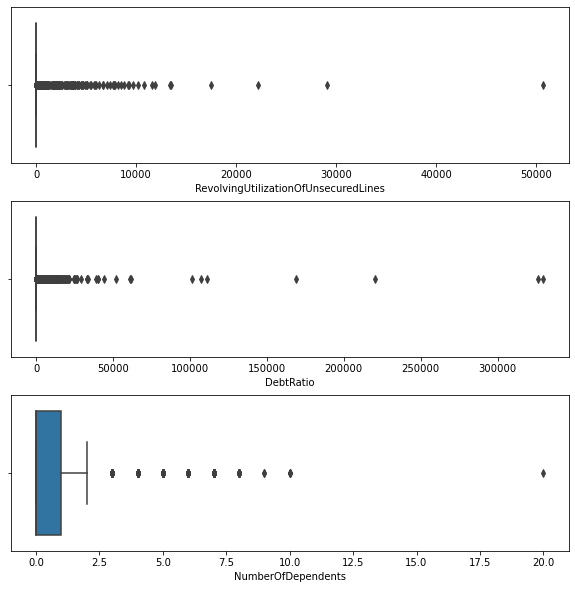

In [9]:
# Since I know roughly what each column should look like, 
# looking at these min and max is enough to think about which have outliers
# For example, you'd expect there to be a massive variance/skew in the monthly income
# Here I look in more depth

lookat = ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'NumberOfDependents']

plt.rcParams['figure.figsize'] = [10, 10]

fig, (ax_1, ax_2 ,ax_3) = plt.subplots(3)
fig.subplots_adjust(hspace = 0.25) 
ax = [ax_1, ax_2, ax_3] # I know this is weird code but can't be bothered finding what the proper fix is
for i in range(3):
    sns.boxplot(ax=ax[i], data=dataset, x=lookat[i])
    
plt.savefig('GMSC-boxplot.pdf')

## Data Tranformations
Now I apply multiple transformations to the dataset, putting it in a more useful form for the classifiers to work with. Specifically I do the following:
- Check which features have the highest kurtosis
- Log transform these features
- Impute missing values with SimpleImputer
- Upsample the minority class

In [10]:
dataset.skew().sort_values(ascending=False)

MonthlyIncome                           128.852253
RevolvingUtilizationOfUnsecuredLines    110.156858
DebtRatio                                93.136502
NumberOfTime60-89DaysPastDueNotWorse     23.206666
NumberOfTimes90DaysLate                  22.978025
NumberOfTime30-59DaysPastDueNotWorse     22.491301
NumberRealEstateLoansOrLines              3.750909
SeriousDlqin2yrs                          3.477883
NumberOfDependents                        1.591755
NumberOfOpenCreditLinesAndLoans           1.192836
age                                       0.187469
Unnamed: 0                                0.000000
dtype: float64

In [11]:
# Remove outliers
dataset = dataset.loc[dataset['RevolvingUtilizationOfUnsecuredLines'] < 15000]
dataset = dataset.loc[dataset['DebtRatio'] < 100000]
dataset = dataset.loc[dataset['NumberOfDependents'] < 10]

# Data is highly skewed, not good not good
def log_transform(datasett):
    dataset_transformed = datasett.copy()

    # Try the log of some of this data to reduce skew
    dataset_transformed['logMonthlyIncome'] = np.log(datasett['MonthlyIncome'] + 1)
    dataset_transformed['logRevolvingUtilizationOfUnsecuredLines'] = np.log(datasett['RevolvingUtilizationOfUnsecuredLines'] + 1)
    dataset_transformed['logDebtRatio'] = np.log(datasett['DebtRatio'] + 1)
    dataset_transformed['logMonthlyIncome'] = np.log(datasett['MonthlyIncome'] + 1)
    dataset_transformed['logNumberOfTime60-89DaysPastDueNotWorse'] = np.log(datasett['NumberOfTime60-89DaysPastDueNotWorse'] + 1)
    dataset_transformed['logNumberOfTime30-59DaysPastDueNotWorse'] = np.log(datasett['NumberOfTime30-59DaysPastDueNotWorse'] + 1)
    dataset_transformed['logNumberOfTimes90DaysLate'] = np.log(datasett['NumberOfTimes90DaysLate'] + 1)

    dataset_transformed.drop(['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome', 
                              'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTime30-59DaysPastDueNotWorse',
                              'NumberOfTimes90DaysLate'], inplace=True, axis=1)
    return dataset_transformed

dataset_transformed = log_transform(dataset)
test_dataset_transformed = log_transform(test_dataset)

In [12]:
dataset_transformed.skew().sort_values(ascending=False)

logRevolvingUtilizationOfUnsecuredLines    11.329325
logNumberOfTime60-89DaysPastDueNotWorse    10.560204
logNumberOfTimes90DaysLate                  8.683401
logNumberOfTime30-59DaysPastDueNotWorse     4.155167
NumberRealEstateLoansOrLines                3.755882
SeriousDlqin2yrs                            3.459557
logDebtRatio                                1.874417
NumberOfDependents                          1.537121
NumberOfOpenCreditLinesAndLoans             1.192880
age                                         0.187704
Unnamed: 0                                 -0.000695
logMonthlyIncome                           -4.370081
dtype: float64

Displaying absolute correlations above the threshold (0.02). Specify a positive "threshold" to limit the results further.


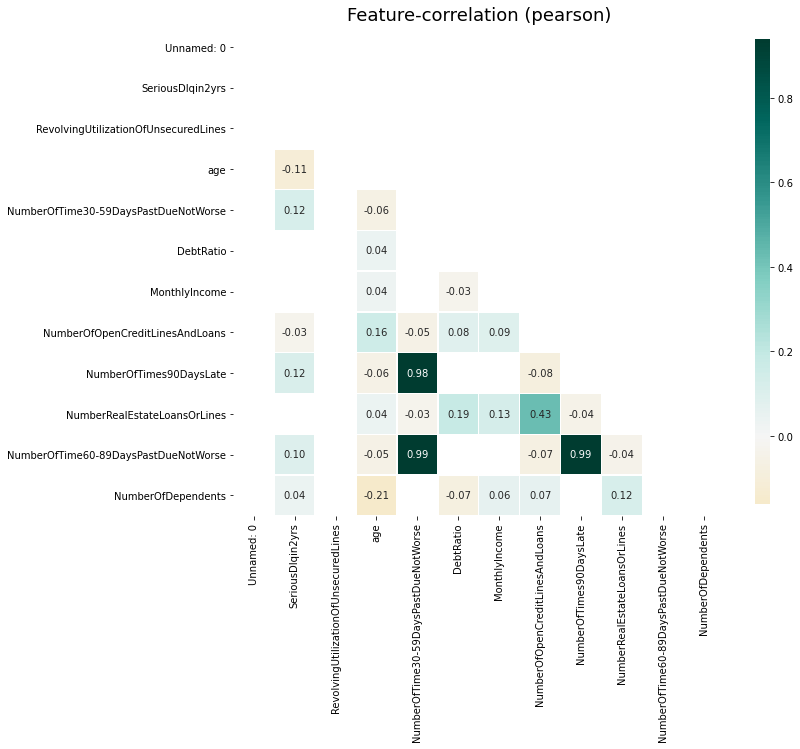

In [13]:
plot = klib.corr_plot(dataset,  figsize=(11,9), split='high', threshold=0.02)

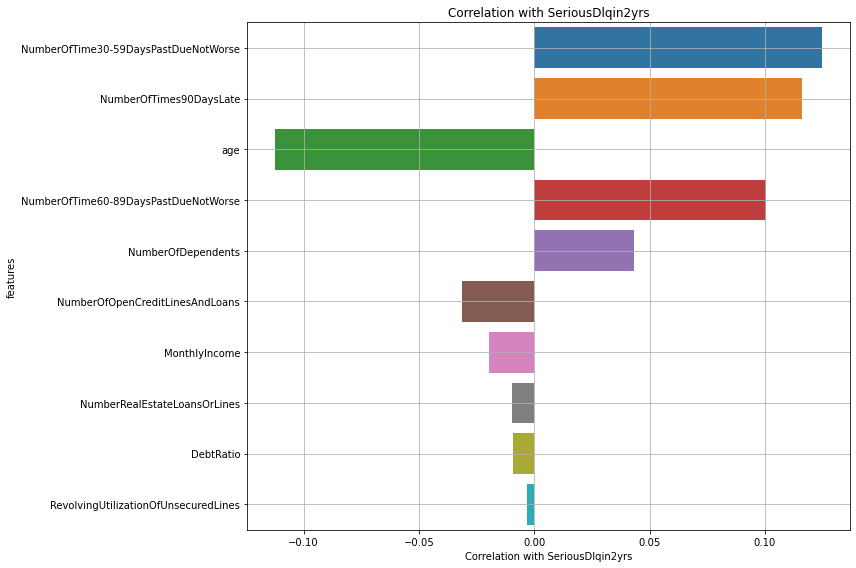

In [14]:
# The feature we wish to predict is 'SeriousDlqin2yrs'. 
# So, let's explore which features have the most correlation with it.

corrmat = dataset.corr()
corr = corrmat['SeriousDlqin2yrs'].sort_values(key=abs, ascending=False)
corr.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], inplace=True)
df = pd.DataFrame(data={'features': corr.index, 'Correlation with SeriousDlqin2yrs': corr.values})
plt.figure(figsize=(12, 8))
sns.barplot(x="Correlation with SeriousDlqin2yrs", y="features", data=df)
plt.title('Correlation with SeriousDlqin2yrs')
plt.grid()
plt.tight_layout()
plt.savefig('GMSCcorrplot.pdf')
plt.show()

In [15]:
y = dataset_transformed['SeriousDlqin2yrs']
print(y.value_counts())
print('\nPercentage of data that has been defaulted on after 2 years:')
print(str( 100 * np.round(y.value_counts()[1] / (y.value_counts()[0] + y.value_counts()[1]), 3)) + '%')

0    102193
1      7354
Name: SeriousDlqin2yrs, dtype: int64

Percentage of data that has been defaulted on after 2 years:
6.7%


In [16]:
# Imputation for missing values; upscaling minority class
imp = PandasSimpleImputer.PandasSimpleImputer(strategy='median', missing_values=np.nan)
df = imp.fit_transform(dataset_transformed)
df_test = imp.transform(test_dataset_transformed)

df_majority = df[df['SeriousDlqin2yrs'] == 0]
df_minority = df[df['SeriousDlqin2yrs'] == 1]

df_minority_upsampled = resample(df_minority,
                                     replace=True,  # sample with replacement
                                     n_samples=len(df_majority),  # to match majority class
                                     random_state=123)  # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df = df_upsampled

In [17]:
# Split training set into X and y and scale
X = df.drop(['SeriousDlqin2yrs','Unnamed: 0'], axis=1)
y = df['SeriousDlqin2yrs']

X_test = df_test.drop(['SeriousDlqin2yrs','Unnamed: 0'], axis=1)
y_test = df_test['SeriousDlqin2yrs']

sc = StandardScaler()
X = sc.fit_transform(X)
X_test = sc.transform(X_test)

In [18]:
print('Upsampling check; should be 50%:')
print(str( 100 * np.round(y.value_counts()[1] / (y.value_counts()[0] + y.value_counts()[1]), 3)) + '%')

Upsampling check; should be 50%:
50.0%


## Training and Testing the Classifiers
Finally I train and test the classifiers using the optimized classifiers found in the notebook that works with optimizing the classifiers. Below this, I look at the feature importance, using the Shap feature importance (SHAP) and the permutation feature importance (Sklearn).

In [19]:
RF = RandomForestClassifier(n_estimators=100)
GBC = GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, 
                                 subsample=1, max_features='sqrt', random_state=10, learning_rate=0.15,
                                 n_estimators=500)
Ada = AdaBoostClassifier(learning_rate=0.5, n_estimators=500)
XGBC = XGBClassifier(max_depth=7, min_child_weight=1, gamma=0.1, colsample_bytree=0.8, 
                                 subsample=0.6, reg_alpha=0, n_estimators=5000, learning_rate=0.01)
LGB = LGBMClassifier(subsample_freq=20, n_estimators=400, num_leaves=100, max_depth=20,
                                colsample_bytree=0.7, min_split_gain=0.3, reg_alpha=1.3, reg_lambda=1.3,
                                subsample=0.8)
MLP = MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(100,), learning_rate='adaptive',
                                solver='adam')

In [20]:
def train_and_run(clf):
    clf.fit(X, y)
    pred_clf = clf.predict(X_test)
    print(confusion_matrix(y_test, pred_clf))
    print(classification_report(y_test, pred_clf))

In [21]:
train_and_run(RF)

[[34211   751]
 [ 1862   676]]
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     34962
         1.0       0.47      0.27      0.34      2538

    accuracy                           0.93     37500
   macro avg       0.71      0.62      0.65     37500
weighted avg       0.92      0.93      0.92     37500



In [22]:
train_and_run(GBC)

[[29017  5945]
 [  698  1840]]
              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90     34962
         1.0       0.24      0.72      0.36      2538

    accuracy                           0.82     37500
   macro avg       0.61      0.78      0.63     37500
weighted avg       0.93      0.82      0.86     37500



In [23]:
train_and_run(Ada)

[[28649  6313]
 [  660  1878]]
              precision    recall  f1-score   support

         0.0       0.98      0.82      0.89     34962
         1.0       0.23      0.74      0.35      2538

    accuracy                           0.81     37500
   macro avg       0.60      0.78      0.62     37500
weighted avg       0.93      0.81      0.85     37500



In [24]:
train_and_run(LGB)

[[31285  3677]
 [ 1014  1524]]
              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93     34962
         1.0       0.29      0.60      0.39      2538

    accuracy                           0.87     37500
   macro avg       0.63      0.75      0.66     37500
weighted avg       0.92      0.87      0.89     37500



In [25]:
train_and_run(MLP)

[[28169  6793]
 [  589  1949]]
              precision    recall  f1-score   support

         0.0       0.98      0.81      0.88     34962
         1.0       0.22      0.77      0.35      2538

    accuracy                           0.80     37500
   macro avg       0.60      0.79      0.61     37500
weighted avg       0.93      0.80      0.85     37500



In [26]:
feature_names = dataset_transformed.drop(['Unnamed: 0', 'SeriousDlqin2yrs'], axis=1).columns

In [27]:
train_and_run(XGBC)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:26:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[30915  4047]
 [  923  1615]]
              precision    recall  f1-score   support

         0.0       0.97      0.88      0.93     34962
         1.0       0.29      0.64      0.39      2538

    accuracy                           0.87     37500
   macro avg       0.63      0.76      0.66     37500
weighted avg       0.92      0.87      0.89     37500



In [28]:
def calc_votes(ys):
    outcomes = []
    for i in range(len(ys[0])):
        votes_positive = sum([y[i] for y in ys])
        results = 1 if votes_positive > len(ys) / 2 else 0
        outcomes.append(results)
    return outcomes
    
def get_voting_prediction(X):
    RF_pred = RF.predict(X)
    GBC_pred = GBC.predict(X)
    Ada_pred = Ada.predict(X)
    XGBC_pred = XGBC.predict(X)
    LGB_pred = LGB.predict(X)
    MLP_pred = MLP.predict(X)
    return calc_votes([RF_pred, GBC_pred, Ada_pred, XGBC_pred, LGB_pred, MLP_pred])

In [29]:
pred_voting = get_voting_prediction(X_test)
print(confusion_matrix(y_test, pred_voting))
print(classification_report(y_test, pred_voting))

[[30908  4054]
 [  895  1643]]
              precision    recall  f1-score   support

         0.0       0.97      0.88      0.93     34962
         1.0       0.29      0.65      0.40      2538

    accuracy                           0.87     37500
   macro avg       0.63      0.77      0.66     37500
weighted avg       0.93      0.87      0.89     37500



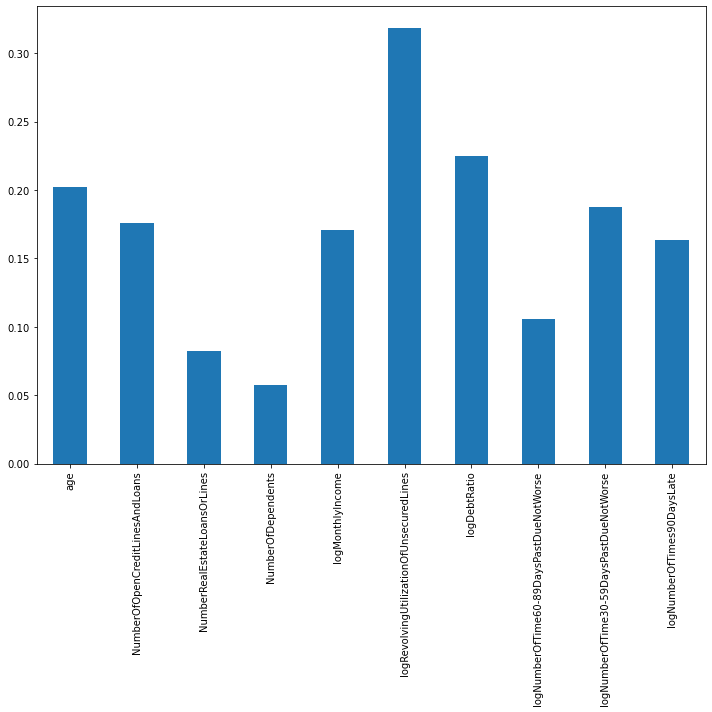

In [30]:
result = permutation_importance(
    RF, X, y, n_repeats=10, random_state=42
)
forest_importances = pd.Series(result.importances_mean, index=feature_names)
forest_importances.plot.bar()
plt.tight_layout()
plt.savefig('GMSC_feature_importance.pdf')

In [31]:
# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(LGB)
shap_values = explainer.shap_values(X_importance)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


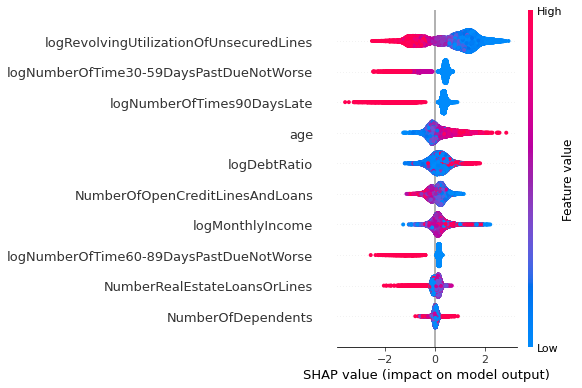

In [32]:
shap.summary_plot(shap_values[0], X_importance, feature_names=feature_names, plot_type='dot', show=False)
plt.tight_layout()
plt.savefig('GMSC_feature_importance2.pdf')

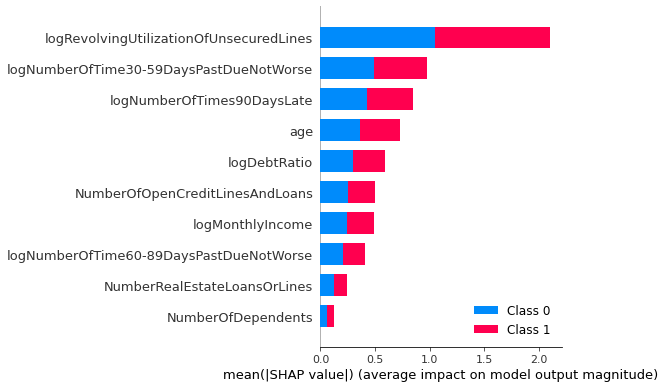

In [33]:
shap.summary_plot(shap_values, X_importance, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig('GMSC_feature_importance3.pdf')